<a href="https://colab.research.google.com/github/gmauricio-toledo/NLP-MCD/blob/main/08-TopicDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Topic Detection</h1>

<h2>Topic Modelling</h1>

En esta notebook ahondaremos un poco más en la tarea de *Topic Detection*. Para esto usaremos varias técnicas, algunas de ellas nuevas:

* Clustering en representaciones vectoriales de documentos.
* LDA. Implementación en [gensim](https://radimrehurek.com/gensim/models/ldamodel.html).
* LSA. Implementación en [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

Además, evaluaremos estas tareas usando métricas propias de la tarea.
* [Coherence](https://radimrehurek.com/gensim/models/coherencemodel.html): [source](https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD

import spacy

from gensim import models, corpora
from gensim.models.coherencemodel import CoherenceModel

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
!pip install wordcloud

Consideraremos un corpus de 92579 documentos de texto, consisten en noticias de CNN.

In [5]:
!gdown 1S-KYaCpb39vMphrkdnceXUkUhzHeapt7

Downloading...
From (original): https://drive.google.com/uc?id=1S-KYaCpb39vMphrkdnceXUkUhzHeapt7
From (redirected): https://drive.google.com/uc?id=1S-KYaCpb39vMphrkdnceXUkUhzHeapt7&confirm=t&uuid=31d99a1d-a956-44da-a20f-faaac376cfd4
To: /content/cnn_articles.txt
100% 365M/365M [00:08<00:00, 43.7MB/s]


In [8]:
with open('cnn_articles.txt', 'r', encoding='utf8') as f:
    articles = f.read().split('@delimiter')

print(len(articles))

cnn_df = pd.DataFrame({'document':articles})
cnn_df

92579


,document
0,-- Children in war-ravaged Afghanistan are sa...
1,"\n -- The Hard Rock Cafe franchise, famed for ..."
2,\nAn estimated 7 million people died due to ai...
3,\n -- A federal judge has temporarily blocked ...
4,"\n -- ""Terrorism and violence cannot be permis..."
...,...
92574,\n -- Pakistan's president has summoned the lo...
92575,\n -- The leader of one of the labs linked to ...
92576,\n -- The president of Florida A&M University ...
92577,"\nThis week, we mark the tenth anniversary of ..."


Nos quedamos solamente con los primeros 10000 artículos.

In [10]:
corpus = articles[:10000]

Exploremos los documentos

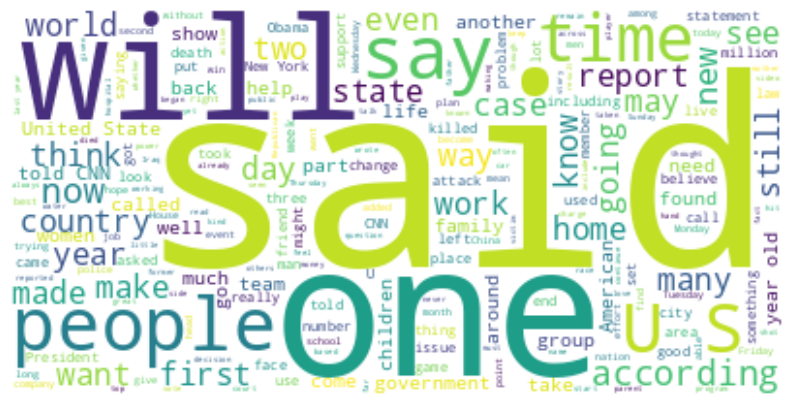

In [54]:
from wordcloud import WordCloud

wc = WordCloud(background_color="white", max_words=2000, contour_width=3, contour_color='steelblue')
wordcloud = wc.generate(" ".join(corpus))

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Hacemos el preprocesamiento usando un pipeline *ligero* de scipy. Tarda alrededor de 40s.

In [11]:
%%time

nlp = spacy.blank('en')

tokenized_docs = [[t.text for t in tok_doc if
          not t.is_punct and \
          not t.is_space and \
          t.is_alpha] for tok_doc in nlp.pipe(corpus) ]

CPU times: user 37.2 s, sys: 563 ms, total: 37.8 s
Wall time: 43 s


In [56]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['said'])

In [57]:
tokenized_docs = [[w for w in doc if w not in stopwords] for doc in tokenized_docs]

In [58]:
print(tokenized_docs[0])

['Children', 'war', 'ravaged', 'Afghanistan', 'safer', 'growing', 'London', 'New', 'York', 'NATO', 'top', 'civilian', 'envoy', 'says', 'Mark', 'Sedwill', 'senior', 'civilian', 'representative', 'NATO', 'made', 'comments', 'episode', 'CBBC', 'Newsround', 'airing', 'Monday', 'In', 'show', 'BBC', 'current', 'affairs', 'program', 'children', 'several', 'youngsters', 'Kabul', 'Afghanistan', 'say', 'afraid', 'daily', 'violence', 'frequent', 'explosions', 'war', 'torn', 'country', 'In', 'response', 'Sedwill', 'says', 'Here', 'Kabul', 'big', 'cities', 'actually', 'bombs', 'The', 'children', 'probably', 'safer', 'would', 'London', 'New', 'York', 'Glasgow', 'many', 'cities', 'Most', 'children', 'go', 'lives', 'safety', 'It', 'family', 'oriented', 'society', 'So', 'little', 'bit', 'like', 'city', 'villages', 'added', 'A', 'report', 'released', 'earlier', 'year', 'seems', 'contradict', 'Sedwill', 'assessment', 'The', 'February', 'report', 'special', 'representative', 'children', 'armed', 'conflict

🛑 Si usamos un pipeline más completo podemos tardar hasta 12 minutos.

In [ ]:
%%time

# nlp = spacy.load("en_core_web_sm", disable=["ner"])

# tokenized_docs = [[t.text for t in tok_doc if
#           not t.is_punct and \
#           not t.is_space and \
#           t.is_alpha] for tok_doc in nlp.pipe(corpus) ]

CPU times: user 11min 31s, sys: 1min 28s, total: 13min
Wall time: 12min 57s


## LSA con scikit-learn

In [59]:
docs = [" ".join(doc) for doc in tokenized_docs]

print(docs[:3])

vectorizer = TfidfVectorizer(stop_words='english',
                            max_features= 1000,
                            smooth_idf=True)

X = vectorizer.fit_transform(docs)

X.shape

['Children war ravaged Afghanistan safer growing London New York NATO top civilian envoy says Mark Sedwill senior civilian representative NATO made comments episode CBBC Newsround airing Monday In show BBC current affairs program children several youngsters Kabul Afghanistan say afraid daily violence frequent explosions war torn country In response Sedwill says Here Kabul big cities actually bombs The children probably safer would London New York Glasgow many cities Most children go lives safety It family oriented society So little bit like city villages added A report released earlier year seems contradict Sedwill assessment The February report special representative children armed conflict says children Afghanistan increasingly victims roadside attacks crossfire militants international forces air strikes In addition used human shields recruited suicide bombers The report also boys sexually abused exploited armed groups girls schools burned Earlier year rash poisonings involving schoo

(10000, 1000)

In [60]:
svd_model = TruncatedSVD(n_components=10, algorithm='randomized',
                         n_iter=100, random_state=122)

svd_model.fit(X)
len(svd_model.components_)

10

In [61]:
terms = vectorizer.get_feature_names_out()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print(f"Topic {str(i)}: ")
    for t in sorted_terms:
        print(t[0], end=', ')
    print()

Topic 0: 
people, police, new, year, cnn, time, world, 
Topic 1: 
police, al, government, military, security, state, killed, 
Topic 2: 
police, authorities, family, officer, county, death, told, 
Topic 3: 
league, al, cup, win, match, team, season, 
Topic 4: 
obama, court, police, president, republican, republicans, senate, 
Topic 5: 
al, iraq, syria, isis, women, syrian, qaeda, 
Topic 6: 
police, obama, officers, people, president, city, house, 
Topic 7: 
police, china, women, chinese, world, korea, party, 
Topic 8: 
korea, north, children, south, korean, family, hospital, 
Topic 9: 
health, women, children, care, disease, patients, hospital, 


## [LDA](https://radimrehurek.com/gensim/models/ldamodel.html) con gensim

El atributo `vocabulary_` de la clase `TfidfVectorizer` es un diccionario de la forma
            
        word: word_index

In [ ]:
vectorizer.vocabulary_

Para el modelo LDA de gensim necesitamos especificar un diccionario de la forma
            
        word_index: word

In [63]:
dicc = dict(zip(vectorizer.vocabulary_.values(),vectorizer.vocabulary_.keys()))

Necesitamos también especificar una matriz sparse de scipy.

In [64]:
from scipy.sparse import csr_matrix

X_csc = csr_matrix(X)

In [65]:
%%time

from gensim.matutils import Sparse2Corpus

lda_model = models.LdaModel(corpus=Sparse2Corpus(X_csc,documents_columns=False), num_topics=10, id2word=dicc, random_state=1)

CPU times: user 5.58 s, sys: 156 ms, total: 5.73 s
Wall time: 5.67 s


In [66]:
lda_model.get_topics().shape

(10, 1000)

In [67]:
word_id = 784

word_topics = lda_model.get_term_topics(word_id=word_id,minimum_probability=0)
word_topics = sorted(word_topics,key=lambda x: x[1], reverse=True)
print(f"Word: {dicc[word_id]}")
print(f"Topics: {word_topics}")

Word: schools
Topics: [(9, 0.002362674), (0, 0.0006202622), (2, 0.0005797419), (7, 0.00045553007), (5, 0.0004304483), (3, 0.0004212707), (6, 0.00039826764), (8, 0.00020650978), (4, 0.000116191455), (1, 7.0470254e-05)]


In [68]:
lda_model.print_topics()

[(0,
  '0.017*"police" + 0.006*"cnn" + 0.006*"authorities" + 0.005*"according" + 0.005*"flight" + 0.005*"plane" + 0.005*"people" + 0.005*"investigation" + 0.005*"told" + 0.005*"hospital"'),
 (1,
  '0.023*"jackson" + 0.010*"chinese" + 0.010*"bank" + 0.009*"japan" + 0.009*"china" + 0.005*"spain" + 0.005*"trial" + 0.005*"court" + 0.005*"million" + 0.005*"michael"'),
 (2,
  '0.007*"family" + 0.007*"police" + 0.006*"told" + 0.005*"cnn" + 0.005*"children" + 0.005*"people" + 0.005*"home" + 0.005*"old" + 0.005*"mother" + 0.004*"county"'),
 (3,
  '0.020*"iran" + 0.015*"israel" + 0.012*"israeli" + 0.011*"oil" + 0.011*"nuclear" + 0.009*"obama" + 0.009*"iranian" + 0.008*"president" + 0.006*"united" + 0.006*"government"'),
 (4,
  '0.019*"al" + 0.018*"iraq" + 0.014*"isis" + 0.012*"military" + 0.011*"afghanistan" + 0.010*"iraqi" + 0.010*"taliban" + 0.009*"qaeda" + 0.008*"forces" + 0.008*"troops"'),
 (5,
  '0.009*"says" + 0.007*"people" + 0.007*"like" + 0.006*"new" + 0.005*"world" + 0.005*"time" + 0.0

Podemos inspeccionar más a detalle un tópico

In [69]:
lda_model.show_topic(topicid=9, topn=15)

[('court', 0.01438678),
 ('women', 0.008980967),
 ('sex', 0.00796543),
 ('marriage', 0.0076342174),
 ('cancer', 0.0074548237),
 ('law', 0.0073690517),
 ('justice', 0.006206399),
 ('drug', 0.0060951705),
 ('rights', 0.006043509),
 ('supreme', 0.005921354),
 ('federal', 0.005458457),
 ('drugs', 0.005368221),
 ('case', 0.005321493),
 ('state', 0.005005267),
 ('states', 0.0048128753)]

In [70]:
word = 'team'
word_id = vectorizer.vocabulary_[word]

word_topics = lda_model.get_term_topics(word_id=word_id,minimum_probability=0)
word_topics = sorted(word_topics,key=lambda x: x[1], reverse=True)
print(f"Word: {word}")
print(f"Topics: {word_topics}")

Word: team
Topics: [(8, 0.009059652), (2, 0.0011578915), (1, 0.0011370323), (5, 0.0010543067), (4, 0.0010160862), (7, 0.0008314111), (6, 0.0007807543), (0, 0.0007576475), (9, 0.00061150896), (3, 0.00046926056)]


In [71]:
lda_model.show_topics(num_topics=10, num_words=10, log=False, formatted=True)

[(0,
  '0.017*"police" + 0.006*"cnn" + 0.006*"authorities" + 0.005*"according" + 0.005*"flight" + 0.005*"plane" + 0.005*"people" + 0.005*"investigation" + 0.005*"told" + 0.005*"hospital"'),
 (1,
  '0.023*"jackson" + 0.010*"chinese" + 0.010*"bank" + 0.009*"japan" + 0.009*"china" + 0.005*"spain" + 0.005*"trial" + 0.005*"court" + 0.005*"million" + 0.005*"michael"'),
 (2,
  '0.007*"family" + 0.007*"police" + 0.006*"told" + 0.005*"cnn" + 0.005*"children" + 0.005*"people" + 0.005*"home" + 0.005*"old" + 0.005*"mother" + 0.004*"county"'),
 (3,
  '0.020*"iran" + 0.015*"israel" + 0.012*"israeli" + 0.011*"oil" + 0.011*"nuclear" + 0.009*"obama" + 0.009*"iranian" + 0.008*"president" + 0.006*"united" + 0.006*"government"'),
 (4,
  '0.019*"al" + 0.018*"iraq" + 0.014*"isis" + 0.012*"military" + 0.011*"afghanistan" + 0.010*"iraqi" + 0.010*"taliban" + 0.009*"qaeda" + 0.008*"forces" + 0.008*"troops"'),
 (5,
  '0.009*"says" + 0.007*"people" + 0.007*"like" + 0.006*"new" + 0.005*"world" + 0.005*"time" + 0.0

In [89]:
from gensim.corpora import Dictionary

dictionary = Dictionary.from_corpus(Sparse2Corpus(X_csc,documents_columns=False), id2word=dicc)
bow = dictionary.doc2bow(tokenized_docs[0])

topics = lda_model.get_document_topics(bow=bow, minimum_probability=None)

print(topics)

[(5, 0.41449162), (6, 0.5769032)]


Evaluación

La coherencia mide la distancia relativa entre palabras dentro de un tópico. Hay dos tipos principales:
* `c_v` típicamente está en $0 < x < 1$.
* `u_mass` típicamente está en $-14 < x < 14$.

In [80]:
cm = CoherenceModel(model=lda_model,
                    coherence='u_mass',
                    corpus=Sparse2Corpus(X_csc,documents_columns=False),
                    )
coherence = cm.get_coherence()
coherence

-1.4997800951929177

Si queremos usar las estrategias: `c_v`, `c_uci`, `c_npmi` tenemos que proporcionar información del corpus.

In [77]:
from gensim.corpora import Dictionary

dictionary = Dictionary.from_corpus(Sparse2Corpus(X_csc,documents_columns=False), id2word=dicc)

cm = CoherenceModel(model=lda_model,
                    corpus=Sparse2Corpus(X_csc,documents_columns=False),
                    coherence='c_v',
                    texts=tokenized_docs,
                    dictionary=dictionary)
coherence = cm.get_coherence()
coherence

nan

También podemos ver la coherencia por tópico:

In [78]:
cm.get_coherence_per_topic()

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.6851627488032638,
 0.4443864333945552]

In [87]:
lda_model.get_topics().shape

(10, 1000)

In [ ]:
lda_model.get_document_topics(corpus_bow[0])
for x in lda_model.get_document_topics(corpus_bow[0]):
  print(x)

(1, 0.09510056)
(5, 0.046983566)
(7, 0.028704988)
(8, 0.8276095)


# 20newsgroups

Podemos repetir el experimento con el corpus `20newsgroups`

In [3]:
train_data = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
test_data = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

X_train = train_data.data
X_test = test_data.data

y_train = train_data.target
y_test = test_data.target

In [ ]:
news_df = pd.DataFrame({'document':X_train,
                        'topic': y_train})
news_df